<a href="https://colab.research.google.com/github/jiissung/ECON3916-Statistical-Machine-Learning/blob/main/Assignment%201/Econ_3916_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# Manual Data Construction
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'Big Mac', 'Price_2016': 5.00, 'Price_2024': 6.60}
]

In [55]:
# Define the "Machine" (Function)
def calculate_inflation(base, current):
    return ((current - base) / base) * 100

# Run the Loop
for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Big Mac: 32.00% Inflation


In [56]:
from fredapi import Fred
fred = Fred(api_key='5db662f99b81cdeea8128328e60f6fec')

# Fetch Series
official_cpi = fred.get_series('CPIAUCSL')
tuition = fred.get_series('CUSR0000SEEB')
rent = fred.get_series('CUSR0000SEHA') # Added Rent
cable = fred.get_series('CUSR0000SERA02')
food = fred.get_series('CUSR0000SEFV')
# ... fetch remaining series

print(official_cpi)

1947-01-01     21.480
1947-02-01     21.620
1947-03-01     22.000
1947-04-01     22.000
1947-05-01     21.950
               ...   
2025-08-01    323.364
2025-09-01    324.368
2025-10-01        NaN
2025-11-01    325.031
2025-12-01    326.030
Length: 948, dtype: float64


In [57]:
import pandas as pd

def value_calc(Value_Current, Value_at_Start_Date):
  Value_Index = (Value_Current / Value_at_Start_Date) * 100
  return Value_Index

base_year = '2016-01-01'

cpi_official_norm = value_calc(official_cpi, official_cpi.loc[base_year])
tuition_norm = value_calc(tuition, tuition.loc[base_year])
rent_norm = value_calc(rent, rent.loc[base_year])
cable_norm = value_calc(cable, cable.loc[base_year])
food_norm = value_calc(food, food.loc[base_year])

print("CPI_Official:", cpi_official_norm)
print("Tuition:", tuition_norm)
print("Rent:", rent_norm)
print("Cable:", cable_norm)
print("Food:", food_norm)

norm_prices = pd.DataFrame({
    'Official_CPI': cpi_official_norm,
    'Tuition': tuition_norm,
    'Rent': rent_norm,
    "Cable": cable_norm,
    "Food": food_norm
    })

print(norm_prices)

CPI_Official: 1947-01-01      9.038426
1947-02-01      9.097336
1947-03-01      9.257233
1947-04-01      9.257233
1947-05-01      9.236194
                 ...    
2025-08-01    136.066181
2025-09-01    136.488647
2025-10-01           NaN
2025-11-01    136.767627
2025-12-01    137.187989
Length: 948, dtype: float64
Tuition: 1978-01-01      8.214321
1978-02-01      8.285750
1978-03-01      8.357179
1978-04-01      8.414322
1978-05-01      8.500036
                 ...    
2025-08-01    127.901262
2025-09-01    128.186549
2025-10-01           NaN
2025-11-01    128.857838
2025-12-01    129.057982
Length: 576, dtype: float64
Rent: 1981-01-01     29.036682
1981-02-01     29.208091
1981-03-01     29.448063
1981-04-01     29.653754
1981-05-01     29.859445
                 ...    
2025-08-01    149.969832
2025-09-01    150.264655
2025-10-01           NaN
2025-11-01    150.454234
2025-12-01    150.851560
Length: 540, dtype: float64
Cable: 1992-01-01     42.288639
1992-02-01     42.522536
1992-

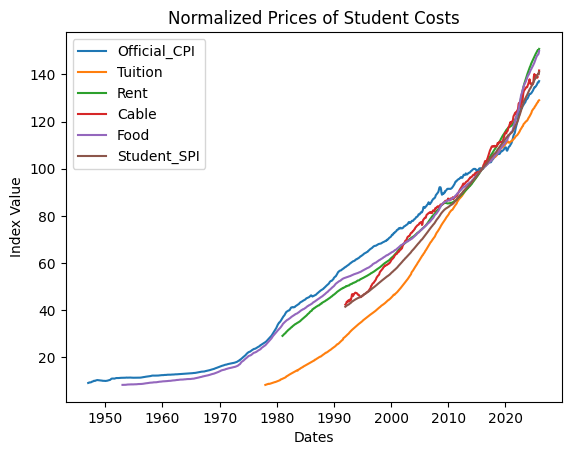

In [65]:
import matplotlib.pyplot as plt


for column in norm_prices.columns:
    plt.plot(norm_prices.index, norm_prices[column], label=column)
    plt.legend()
    plt.title("Normalized Prices of Student Costs")
    plt.xlabel("Dates")
    plt.ylabel("Index Value")


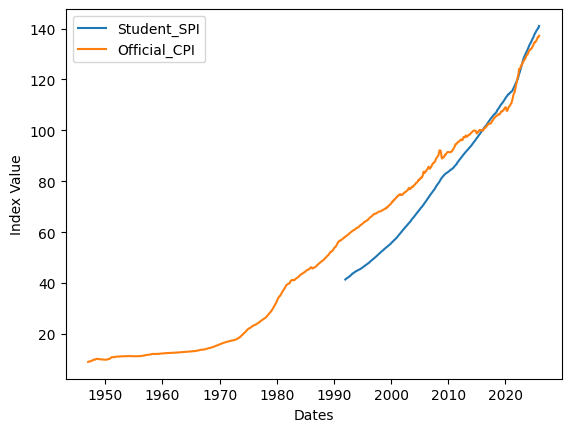

In [68]:
weights = {'Tuition': 0.4,'Rent': 0.3,'Food': 0.2,'Cable': 0.1}

norm_prices['Student_SPI'] = (
    norm_prices['Tuition'] * weights['Tuition'] +
    norm_prices['Rent'] * weights['Rent'] +
    norm_prices['Food'] * weights['Food'] +
    norm_prices['Cable'] * weights['Cable']
)

plt.plot(norm_prices.index, norm_prices['Student_SPI'])
plt.plot(norm_prices.index, norm_prices['Official_CPI'])
plt.legend(['Student_SPI', "Official_CPI"])
plt.ylabel("Index Value")
plt.xlabel("Dates")
plt.show()

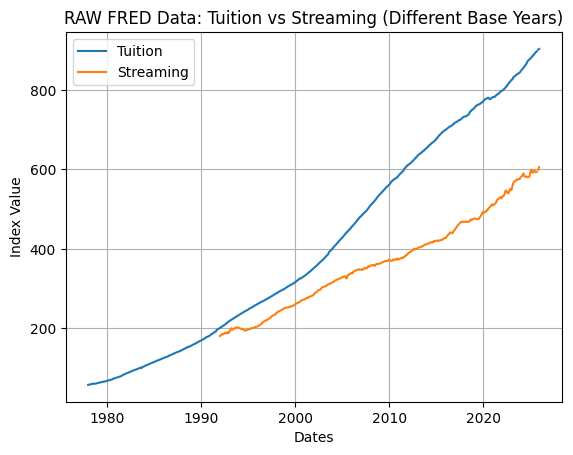

In [69]:
plt.plot(tuition, label='Tuition')
plt.plot(cable, label='Streaming')

plt.title("RAW FRED Data: Tuition vs Streaming (Different Base Years)")
plt.xlabel("Dates")
plt.ylabel("Index Value")
plt.legend()
plt.grid(True)

plt.show()

Comparing raw indices with different bases is a "Data Crime" because it leads to misleading comparisons between the data. Because Tuition starts in the 1980s, it would seem like tuition gained huge inflation compared to streaming.

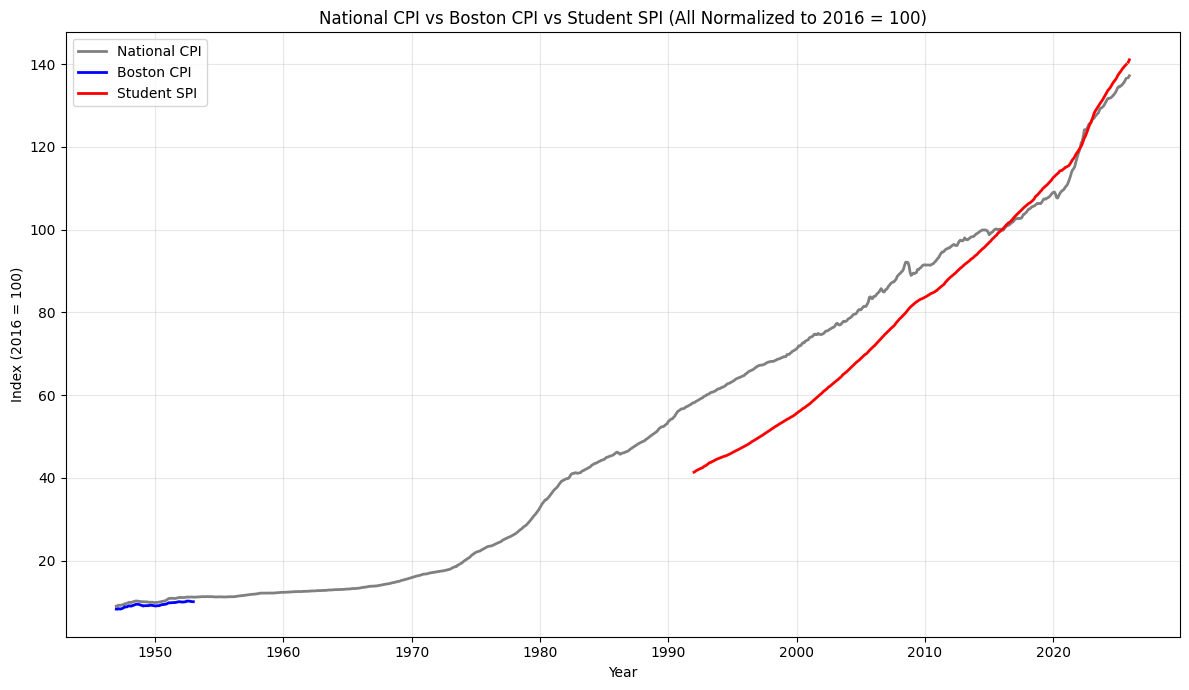

In [73]:
fred = Fred(api_key="5db662f99b81cdeea8128328e60f6fec")  # replace with your FRED API key

# National CPI (already in your df maybe, but refetch to be sure)
national_cpi = fred.get_series("CPIAUCSL")

# Boston CPI (All items)
boston_cpi = fred.get_series("CUURA103SA0")  # Boston CPI index series :contentReference[oaicite:1]{index=1}

# —————————————————————
# 2) Normalize to 2016 = 100
# —————————————————————

def normalize_to_base(series, base_date="2016-01-01"):
    """
    Value_Index = (Value_Current / Value_at_Start_Date) * 100
    Ensures base_date exists in the index; uses nearest earlier if not exact.
    """
    # Ensure base_date exists; if not, find nearest earlier timestamp
    if base_date not in series.index:
        base_date = series.index.asof(pd.to_datetime(base_date))
    base_value = series.loc[base_date]
    return (series / base_value) * 100

# Normalize all series
national_cpi_norm = normalize_to_base(national_cpi)
boston_cpi_norm = normalize_to_base(boston_cpi)

# —————————————————————
# 3) Combine into a DataFrame
# —————————————————————

# Assuming df contains your Student_SPI already normalized to 2016 = 100
df_combined = pd.DataFrame({
    "National CPI": national_cpi_norm,
    "Boston CPI": boston_cpi_norm,
})

# Merge Student_SPI from your existing df (aligned on the same time index)
df_combined = df_combined.join(norm_prices["Student_SPI"], how="inner")

# —————————————————————
# 4) Plot
# —————————————————————

plt.figure(figsize=(12, 7))

plt.plot(df_combined.index, df_combined["National CPI"], label="National CPI", color="grey", linewidth=2)
plt.plot(df_combined.index, df_combined["Boston CPI"], label="Boston CPI", color="blue", linewidth=2)
plt.plot(df_combined.index, df_combined["Student_SPI"], label="Student SPI", color="red", linewidth=2)

plt.title("National CPI vs Boston CPI vs Student SPI (All Normalized to 2016 = 100)")
plt.xlabel("Year")
plt.ylabel("Index (2016 = 100)")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()